# tinycodec

This notebook will track my experiments with video compression and developing the tinycodec software encoder and FPGA decoder. This will not be a compliant implementation of the standard, just a couple of experiments playing around with compression ideas.

The tinycodec experiments are inspired by [1], which is a great book explaining the details of video compression.

[1] Iain Richardson, *H.264 and MPEG-4 Video Compression: Video Coding for Next-generation Multimedia*, John Wiley & Sons, 2003.

In [3]:
import ffmpeg
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: Introduction

Below is a standard DPCM/DCT model for video codecs. The DPCM/DCT model underlies many video coding standards including H.263, H.264, MPEG-2, MPEG-4, and H.265.

<div align="center">
<img src="./data/intro.png" width="750"/>
</div>

In [4]:
probe = ffmpeg.probe('data/test.mov')
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])

In [5]:
def get_frame(i):
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

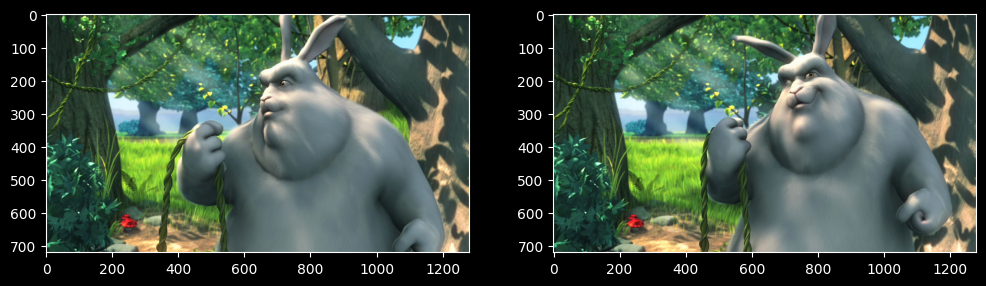

In [6]:
frame1 = get_frame(249)
frame2 = get_frame(250)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].imshow(frame1)
ax[1].imshow(frame2)

plt.show();

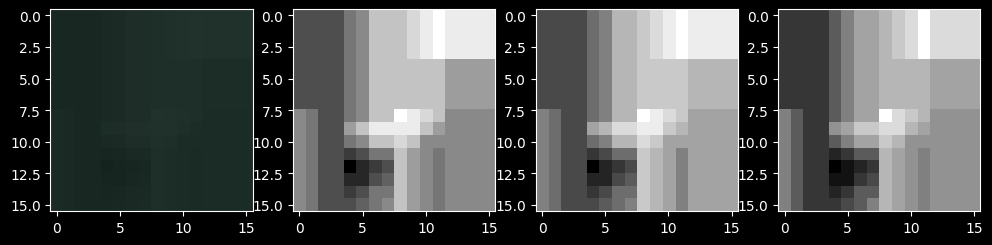

In [7]:
fig, ax = plt.subplots(1,4, figsize=(12,4))
ax[0].imshow(frame1[0:16,0:16])
ax[1].imshow(frame1[0:16,0:16,0], cmap='gray')
ax[2].imshow(frame1[0:16,0:16,1], cmap='gray')
ax[3].imshow(frame1[0:16,0:16,2], cmap='gray')
plt.show()

# Part 2: Color Space Conversion

The human visual system (HVS) is less sensitive to colour than to luminance (brightness). In the RGB colour space the three colours are equally important and so are usually all stored at the same resolution but it is possible to represent a colour image more efficiently by separating the luminance from the colour information and representing luma with a higher resolution than colour.

We will use the following conversion matrix to convert from RGB space to YUV space:

$$\begin{bmatrix}
Y\\
U\\
V
\end{bmatrix} =
\begin{bmatrix}
0.299 & 0.587 & 0.114 \\
-0.1687 & -0.3313 & 0.5 \\
0.5 & -0.4187 & -0.0813
\end{bmatrix}
\begin{bmatrix}
R\\
G\\
B
\end{bmatrix}$$

In [20]:
def rgb_to_yuv(frame):
    X = np.zeros_like(frame)
    R = frame[:,:,0]
    G = frame[:,:,1]
    B = frame[:,:,2]

    X[:,:,0] = 0.299*R + 0.587*G + 0.114*B
    X[:,:,1] = -0.1687*R + -0.3313*G + 0.5*B
    X[:,:,2] = 0.5*R + -0.4187*G + -0.0813*B

    return X

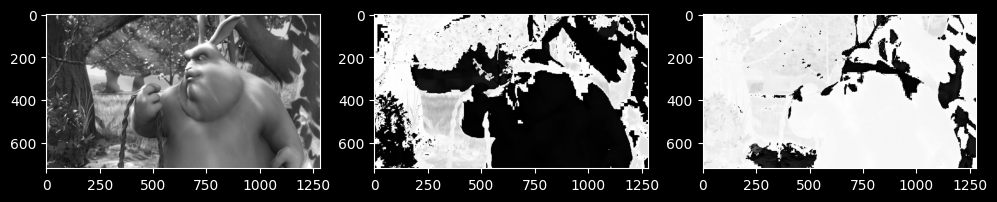

In [32]:
frame1_yuv = rgb_to_yuv(frame1)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(frame1_yuv[:,:,0], label='Y', cmap='grey')
ax[1].imshow(frame1_yuv[:,:,1], label='U', cmap='grey')
ax[2].imshow(frame1_yuv[:,:,2], label='V', cmap='grey')
plt.show()

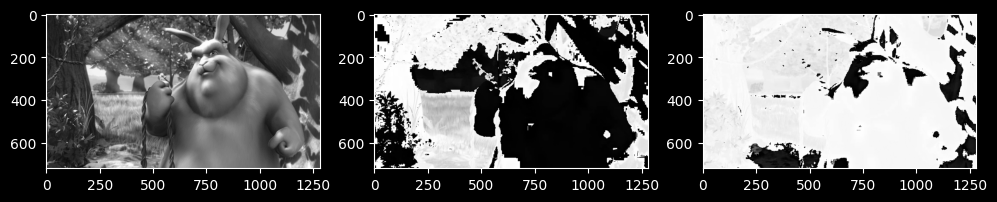

In [34]:
frame2_yuv = rgb_to_yuv(frame2)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(frame2_yuv[:,:,0], label='Y', cmap='grey')
ax[1].imshow(frame2_yuv[:,:,1], label='U', cmap='grey')
ax[2].imshow(frame2_yuv[:,:,2], label='V', cmap='grey')
plt.show()

## Part 3: Chroma Subsampling